


*   This code has been written in **google colab**.

*   If you are running this code on other platforms or IDEs, should change some little things in this notebook. 




In [1]:
!git clone https://github.com/phdong21/CNN4CE.git

Cloning into 'CNN4CE'...
remote: Enumerating objects: 116, done.
remote: Total 116 (delta 0), reused 0 (delta 0), pack-reused 116
Receiving objects: 100% (116/116), 56.46 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import os
import scipy.io as sio
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# SF-CNN

In [44]:
from numpy import *
Nt=32
Nt_beam=32
Nr=16
Nr_beam=16
SNR=10.0**(0/10.0) # transmit power
# DFT matrix
def DFT_matrix(N):
    m, n = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1j / N )
    D = np.power( omega, m * n )
    return D

F_DFT=DFT_matrix(Nt)/np.sqrt(Nt)
F_RF=F_DFT[:,0:Nt_beam]
F=F_RF
F_conjtransp=np.transpose(np.conjugate(F))
FFH=np.dot(F,F_conjtransp)
invFFH=np.linalg.inv(FFH)
pinvF=np.dot(F_conjtransp,invFFH)

W_DFT=DFT_matrix(Nr)/np.sqrt(Nr)
W_RF=W_DFT[:,0:Nr_beam]
W=W_RF
W_conjtransp=np.transpose(np.conjugate(W))

scale=2
fre=2

############## training set generation ##################
data_num_train=1000
data_num_file=1000
H_train=np.zeros((data_num_train,Nr,Nt,2*fre), dtype=float)
H_train_noisy=np.zeros((data_num_train,Nr_beam,Nt_beam,2*fre), dtype=float)
filedir = os.listdir('/content/CNN4CE/SF-CNN/2fre_data')  # type the path of training data
n=0
SNRr=0
SNR_factor=5.9  # compensate channel power gain to approximate to 1
for filename in filedir:
    newname = os.path.join('/content/CNN4CE/SF-CNN/2fre_data', filename)
    data = sio.loadmat(newname)
    channel = data['ChannelData_fre']
    for i in range(data_num_file):
        for j in range(fre):
            a=channel[:,:,j,i]
            H=np.transpose(a)
            H_re = np.real(H)
            H_im = np.imag(H)
            H_train[n*data_num_file+i,:,:,2*j]=H_re/scale
            H_train[n*data_num_file+i, :, :, 2*j+1] = H_im/scale
            N = np.random.normal(0, 1 / np.sqrt(2), size=(Nr, Nt_beam)) + 1j * np.random.normal(0, 1 / np.sqrt(2), size=(Nr, Nt_beam))
            NpinvF=np.dot(N,pinvF)
            Y = H + 1.0 / np.sqrt(SNR_factor*SNR) * NpinvF
            SNRr = SNRr + SNR_factor*SNR * (LA.norm(H)) ** 2 / (LA.norm(NpinvF)) ** 2
            Y_re = np.real(Y)
            Y_im = np.imag(Y)
            H_train_noisy[n*data_num_file+i, :, :, 2 * j] = Y_re / scale
            H_train_noisy[n*data_num_file+i, :, :, 2 * j + 1] = Y_im / scale
    n=n+1
print(n)
print(SNRr/(data_num_train*fre))
print(H_train.shape,H_train_noisy.shape)
index1=np.where(abs(H_train)>1)
row_num= np.unique(index1[0])
H_train=np.delete(H_train,row_num,axis=0)
H_train_noisy=np.delete(H_train_noisy,row_num,axis=0)
print(len(row_num))
print(H_train.shape,H_train_noisy.shape)

1
0.9891929180521922
(1000, 16, 32, 4) (1000, 16, 32, 4)
1
(999, 16, 32, 4) (999, 16, 32, 4)


## Dataset 

In [45]:
class mydataset(Dataset):
  def __init__(self , datas , labels):
    super(mydataset,self).__init__()
    self.datas = torch.tensor(datas , dtype=torch.float)
    self.datas = torch.permute(self.datas, (0,3,1,2)) # must to use torch.permute beacuse the channel must be after batch size [batch_size , channel , nr , nt]
    self.labels = torch.tensor(labels , dtype=torch.float)
    self.labels = torch.permute(self.labels, (0,3,1,2)) #  must to use torch.permute beacuse the channel must be after batch size [batch_size , channel , nr , nt]
  def __getitem__(self, index):
    return self.datas[index] , self.labels[index]
  def __len__(self):
    return self.datas.shape[0]

In [46]:
trainset = mydataset(H_train , H_train_noisy)
batch_size = 128
trainloader = DataLoader(trainset , batch_size = batch_size , shuffle = True)

In [47]:
x = trainset.__getitem__(0)
x[0].shape

torch.Size([4, 16, 32])

## Model

In [48]:
import torch.nn as nn
# biulding the model
class MyModel(nn.Module):
    def __init__(self, input_dim, K, fre):
        super(MyModel, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=input_dim, out_channels=64, kernel_size=(K,K), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(K,K), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(K,K), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(K,K), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(K,K), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(K,K), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(K,K), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(K,K), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=2*fre, kernel_size=(K,K), padding='same'),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x


In [49]:
model = MyModel(input_dim=4 , K=3, fre=2).to(device)

# for testing model
x=torch.randn(64,4,16,32).to(device)
model(x).shape


torch.Size([64, 4, 16, 32])

## Default setting

In [50]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001,weight_decay=0.005,eps=1e-08) #define the optimizer
criterion = nn.MSELoss() #define the loss function 

In [51]:
'''
  this class is for calculating the final loss of each epoch
'''
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [52]:
import logging
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('CNN 4 CE: ')

In [53]:
import sys
import logging
from tqdm import tqdm

## Train function

In [54]:
train_loss=[]
snr=[]
def train_network(model, train_loader, train_dataset):
  epoch_accuracy = []
  total_loss = AverageMeter()
  model.train()
  num_corrects =0.0
  for (x, labels) in tqdm(train_loader): #for each batch calculate something for 1 epoch.
    x, labels = x.to(device) , labels.to(device)
    outputs = model(x)
    loss = criterion(outputs, labels) #loss between out and lables
    optimizer.zero_grad() #befor use next line better to use zero.grad( )
    loss.backward()
    optimizer.step()
    total_loss.update(loss)
  snr.append(total_loss.avg.cpu().detach().numpy())
  train_loss.append(total_loss.avg.cpu().detach().numpy() )
  logger.info(f'Train: Epoch:{epoch} \t Loss:{total_loss.avg:.4}')
  return 

## Training model

In [55]:
start , end = 0,200
for epoch in range(start , end):
  train_network(model, trainloader, trainset)
  # test(model, testloader, testset)
  print()

100%|██████████| 8/8 [00:00<00:00, 26.63it/s]
INFO:CNN 4 CE: :Train: Epoch:0 	 Loss:0.08717


100%|██████████| 8/8 [00:00<00:00, 34.11it/s]
INFO:CNN 4 CE: :Train: Epoch:1 	 Loss:0.05059


100%|██████████| 8/8 [00:00<00:00, 34.12it/s]
INFO:CNN 4 CE: :Train: Epoch:2 	 Loss:0.03829


100%|██████████| 8/8 [00:00<00:00, 34.05it/s]
INFO:CNN 4 CE: :Train: Epoch:3 	 Loss:0.03322


100%|██████████| 8/8 [00:00<00:00, 34.17it/s]
INFO:CNN 4 CE: :Train: Epoch:4 	 Loss:0.03091


100%|██████████| 8/8 [00:00<00:00, 34.55it/s]
INFO:CNN 4 CE: :Train: Epoch:5 	 Loss:0.02963


100%|██████████| 8/8 [00:00<00:00, 34.40it/s]
INFO:CNN 4 CE: :Train: Epoch:6 	 Loss:0.02881


100%|██████████| 8/8 [00:00<00:00, 33.14it/s]
INFO:CNN 4 CE: :Train: Epoch:7 	 Loss:0.02815


100%|██████████| 8/8 [00:00<00:00, 34.13it/s]
INFO:CNN 4 CE: :Train: Epoch:8 	 Loss:0.02771


100%|██████████| 8/8 [00:00<00:00, 34.29it/s]
INFO:CNN 4 CE: :Train: Epoch:9 	 Loss:0.02739


100%|██████████| 8/8 [00:00<00:00, 34.67it/s]
INFO:CNN 4 CE: :Train: Epoch:10 	 Loss:0.02702


100%|██████████| 8/8 [00:00<00:00, 34.71it/s]
INFO:CNN 4 CE: :Train: Epoch:11 	 Loss:0.0269


100%|██████████| 8/8 [00:00<00:00, 34.28it/s]
INFO:CNN 4 CE: :Train: Epoch:12 	 Loss:0.02645


100%|██████████| 8/8 [00:00<00:00, 34.05it/s]
INFO:CNN 4 CE: :Train: Epoch:13 	 Loss:0.0263


100%|██████████| 8/8 [00:00<00:00, 33.87it/s]
INFO:CNN 4 CE: :Train: Epoch:14 	 Loss:0.02612


100%|██████████| 8/8 [00:00<00:00, 33.72it/s]
INFO:CNN 4 CE: :Train: Epoch:15 	 Loss:0.02579


100%|██████████| 8/8 [00:00<00:00, 34.49it/s]
INFO:CNN 4 CE: :Train: Epoch:16 	 Loss:0.02557


100%|██████████| 8/8 [00:00<00:00, 34.30it/s]
INFO:CNN 4 CE: :Train: Epoch:17 	 Loss:0.02538


100%|██████████| 8/8 [00:00<00:00, 34.28it/s]
INFO:CNN 4 CE: :Train: Epoch:18 	 Loss:0.02517


100%|██████████| 8/8 [00:00<00:00, 34.42it/s]
INFO:CNN 4 CE: :Train: Epoch:19 	 Loss:0.02499


100%|██████████| 8/8 [00:00<00:00, 34.37it/s]
INFO:CNN 4 CE: :Train: Epoch:20 	 Loss:0.02491


100%|██████████| 8/8 [00:00<00:00, 34.51it/s]
INFO:CNN 4 CE: :Train: Epoch:21 	 Loss:0.02473


100%|██████████| 8/8 [00:00<00:00, 34.31it/s]
INFO:CNN 4 CE: :Train: Epoch:22 	 Loss:0.02458


100%|██████████| 8/8 [00:00<00:00, 34.19it/s]
INFO:CNN 4 CE: :Train: Epoch:23 	 Loss:0.02439


100%|██████████| 8/8 [00:00<00:00, 34.39it/s]
INFO:CNN 4 CE: :Train: Epoch:24 	 Loss:0.02427


100%|██████████| 8/8 [00:00<00:00, 34.30it/s]
INFO:CNN 4 CE: :Train: Epoch:25 	 Loss:0.02411


100%|██████████| 8/8 [00:00<00:00, 34.32it/s]
INFO:CNN 4 CE: :Train: Epoch:26 	 Loss:0.02403


100%|██████████| 8/8 [00:00<00:00, 34.06it/s]
INFO:CNN 4 CE: :Train: Epoch:27 	 Loss:0.02394


100%|██████████| 8/8 [00:00<00:00, 34.49it/s]
INFO:CNN 4 CE: :Train: Epoch:28 	 Loss:0.02382


100%|██████████| 8/8 [00:00<00:00, 34.17it/s]
INFO:CNN 4 CE: :Train: Epoch:29 	 Loss:0.02363


100%|██████████| 8/8 [00:00<00:00, 34.25it/s]
INFO:CNN 4 CE: :Train: Epoch:30 	 Loss:0.02363


100%|██████████| 8/8 [00:00<00:00, 34.16it/s]
INFO:CNN 4 CE: :Train: Epoch:31 	 Loss:0.02341


100%|██████████| 8/8 [00:00<00:00, 34.22it/s]
INFO:CNN 4 CE: :Train: Epoch:32 	 Loss:0.02335


100%|██████████| 8/8 [00:00<00:00, 34.11it/s]
INFO:CNN 4 CE: :Train: Epoch:33 	 Loss:0.02335


100%|██████████| 8/8 [00:00<00:00, 34.36it/s]
INFO:CNN 4 CE: :Train: Epoch:34 	 Loss:0.02335


100%|██████████| 8/8 [00:00<00:00, 34.22it/s]
INFO:CNN 4 CE: :Train: Epoch:35 	 Loss:0.02331


100%|██████████| 8/8 [00:00<00:00, 34.17it/s]
INFO:CNN 4 CE: :Train: Epoch:36 	 Loss:0.02308


100%|██████████| 8/8 [00:00<00:00, 34.09it/s]
INFO:CNN 4 CE: :Train: Epoch:37 	 Loss:0.02309


100%|██████████| 8/8 [00:00<00:00, 34.07it/s]
INFO:CNN 4 CE: :Train: Epoch:38 	 Loss:0.02287


100%|██████████| 8/8 [00:00<00:00, 33.97it/s]
INFO:CNN 4 CE: :Train: Epoch:39 	 Loss:0.02285


100%|██████████| 8/8 [00:00<00:00, 34.16it/s]
INFO:CNN 4 CE: :Train: Epoch:40 	 Loss:0.02287


100%|██████████| 8/8 [00:00<00:00, 34.34it/s]
INFO:CNN 4 CE: :Train: Epoch:41 	 Loss:0.02269


100%|██████████| 8/8 [00:00<00:00, 33.52it/s]
INFO:CNN 4 CE: :Train: Epoch:42 	 Loss:0.02268


100%|██████████| 8/8 [00:00<00:00, 33.53it/s]
INFO:CNN 4 CE: :Train: Epoch:43 	 Loss:0.02256


100%|██████████| 8/8 [00:00<00:00, 33.31it/s]
INFO:CNN 4 CE: :Train: Epoch:44 	 Loss:0.02251


100%|██████████| 8/8 [00:00<00:00, 32.78it/s]
INFO:CNN 4 CE: :Train: Epoch:45 	 Loss:0.02246


100%|██████████| 8/8 [00:00<00:00, 33.47it/s]
INFO:CNN 4 CE: :Train: Epoch:46 	 Loss:0.02235


100%|██████████| 8/8 [00:00<00:00, 33.20it/s]
INFO:CNN 4 CE: :Train: Epoch:47 	 Loss:0.02229


100%|██████████| 8/8 [00:00<00:00, 33.67it/s]
INFO:CNN 4 CE: :Train: Epoch:48 	 Loss:0.02223


100%|██████████| 8/8 [00:00<00:00, 33.74it/s]
INFO:CNN 4 CE: :Train: Epoch:49 	 Loss:0.02222


100%|██████████| 8/8 [00:00<00:00, 33.61it/s]
INFO:CNN 4 CE: :Train: Epoch:50 	 Loss:0.02224


100%|██████████| 8/8 [00:00<00:00, 33.86it/s]
INFO:CNN 4 CE: :Train: Epoch:51 	 Loss:0.02217


100%|██████████| 8/8 [00:00<00:00, 34.11it/s]
INFO:CNN 4 CE: :Train: Epoch:52 	 Loss:0.02213


100%|██████████| 8/8 [00:00<00:00, 34.30it/s]
INFO:CNN 4 CE: :Train: Epoch:53 	 Loss:0.02212


100%|██████████| 8/8 [00:00<00:00, 34.23it/s]
INFO:CNN 4 CE: :Train: Epoch:54 	 Loss:0.02205


100%|██████████| 8/8 [00:00<00:00, 34.01it/s]
INFO:CNN 4 CE: :Train: Epoch:55 	 Loss:0.02197


100%|██████████| 8/8 [00:00<00:00, 34.21it/s]
INFO:CNN 4 CE: :Train: Epoch:56 	 Loss:0.02195


100%|██████████| 8/8 [00:00<00:00, 34.31it/s]
INFO:CNN 4 CE: :Train: Epoch:57 	 Loss:0.02187


100%|██████████| 8/8 [00:00<00:00, 34.01it/s]
INFO:CNN 4 CE: :Train: Epoch:58 	 Loss:0.02179


100%|██████████| 8/8 [00:00<00:00, 33.95it/s]
INFO:CNN 4 CE: :Train: Epoch:59 	 Loss:0.02175


100%|██████████| 8/8 [00:00<00:00, 34.26it/s]
INFO:CNN 4 CE: :Train: Epoch:60 	 Loss:0.02175


100%|██████████| 8/8 [00:00<00:00, 33.26it/s]
INFO:CNN 4 CE: :Train: Epoch:61 	 Loss:0.02179


100%|██████████| 8/8 [00:00<00:00, 34.23it/s]
INFO:CNN 4 CE: :Train: Epoch:62 	 Loss:0.02175


100%|██████████| 8/8 [00:00<00:00, 33.97it/s]
INFO:CNN 4 CE: :Train: Epoch:63 	 Loss:0.02186


100%|██████████| 8/8 [00:00<00:00, 34.07it/s]
INFO:CNN 4 CE: :Train: Epoch:64 	 Loss:0.02184


100%|██████████| 8/8 [00:00<00:00, 34.22it/s]
INFO:CNN 4 CE: :Train: Epoch:65 	 Loss:0.02167


100%|██████████| 8/8 [00:00<00:00, 33.75it/s]
INFO:CNN 4 CE: :Train: Epoch:66 	 Loss:0.0216


100%|██████████| 8/8 [00:00<00:00, 34.11it/s]
INFO:CNN 4 CE: :Train: Epoch:67 	 Loss:0.02153


100%|██████████| 8/8 [00:00<00:00, 34.12it/s]
INFO:CNN 4 CE: :Train: Epoch:68 	 Loss:0.02163


100%|██████████| 8/8 [00:00<00:00, 34.09it/s]
INFO:CNN 4 CE: :Train: Epoch:69 	 Loss:0.02172


100%|██████████| 8/8 [00:00<00:00, 34.14it/s]
INFO:CNN 4 CE: :Train: Epoch:70 	 Loss:0.02165


100%|██████████| 8/8 [00:00<00:00, 33.77it/s]
INFO:CNN 4 CE: :Train: Epoch:71 	 Loss:0.02158


100%|██████████| 8/8 [00:00<00:00, 33.83it/s]
INFO:CNN 4 CE: :Train: Epoch:72 	 Loss:0.02163


100%|██████████| 8/8 [00:00<00:00, 33.68it/s]
INFO:CNN 4 CE: :Train: Epoch:73 	 Loss:0.02152


100%|██████████| 8/8 [00:00<00:00, 33.92it/s]
INFO:CNN 4 CE: :Train: Epoch:74 	 Loss:0.02142


100%|██████████| 8/8 [00:00<00:00, 33.60it/s]
INFO:CNN 4 CE: :Train: Epoch:75 	 Loss:0.02139


100%|██████████| 8/8 [00:00<00:00, 34.05it/s]
INFO:CNN 4 CE: :Train: Epoch:76 	 Loss:0.0213


100%|██████████| 8/8 [00:00<00:00, 34.01it/s]
INFO:CNN 4 CE: :Train: Epoch:77 	 Loss:0.02142


100%|██████████| 8/8 [00:00<00:00, 34.09it/s]
INFO:CNN 4 CE: :Train: Epoch:78 	 Loss:0.02139


100%|██████████| 8/8 [00:00<00:00, 32.10it/s]
INFO:CNN 4 CE: :Train: Epoch:79 	 Loss:0.02128


100%|██████████| 8/8 [00:00<00:00, 33.88it/s]
INFO:CNN 4 CE: :Train: Epoch:80 	 Loss:0.02128


100%|██████████| 8/8 [00:00<00:00, 33.75it/s]
INFO:CNN 4 CE: :Train: Epoch:81 	 Loss:0.02119


100%|██████████| 8/8 [00:00<00:00, 33.48it/s]
INFO:CNN 4 CE: :Train: Epoch:82 	 Loss:0.02123


100%|██████████| 8/8 [00:00<00:00, 34.25it/s]
INFO:CNN 4 CE: :Train: Epoch:83 	 Loss:0.02135


100%|██████████| 8/8 [00:00<00:00, 34.19it/s]
INFO:CNN 4 CE: :Train: Epoch:84 	 Loss:0.02138


100%|██████████| 8/8 [00:00<00:00, 33.72it/s]
INFO:CNN 4 CE: :Train: Epoch:85 	 Loss:0.02123


100%|██████████| 8/8 [00:00<00:00, 34.00it/s]
INFO:CNN 4 CE: :Train: Epoch:86 	 Loss:0.02119


100%|██████████| 8/8 [00:00<00:00, 33.77it/s]
INFO:CNN 4 CE: :Train: Epoch:87 	 Loss:0.02106


100%|██████████| 8/8 [00:00<00:00, 33.99it/s]
INFO:CNN 4 CE: :Train: Epoch:88 	 Loss:0.02106


100%|██████████| 8/8 [00:00<00:00, 33.16it/s]
INFO:CNN 4 CE: :Train: Epoch:89 	 Loss:0.02103


100%|██████████| 8/8 [00:00<00:00, 33.67it/s]
INFO:CNN 4 CE: :Train: Epoch:90 	 Loss:0.02098


100%|██████████| 8/8 [00:00<00:00, 33.59it/s]
INFO:CNN 4 CE: :Train: Epoch:91 	 Loss:0.02098


100%|██████████| 8/8 [00:00<00:00, 32.96it/s]
INFO:CNN 4 CE: :Train: Epoch:92 	 Loss:0.02106


100%|██████████| 8/8 [00:00<00:00, 33.52it/s]
INFO:CNN 4 CE: :Train: Epoch:93 	 Loss:0.02097


100%|██████████| 8/8 [00:00<00:00, 33.06it/s]
INFO:CNN 4 CE: :Train: Epoch:94 	 Loss:0.02087


100%|██████████| 8/8 [00:00<00:00, 33.67it/s]
INFO:CNN 4 CE: :Train: Epoch:95 	 Loss:0.02088


100%|██████████| 8/8 [00:00<00:00, 33.59it/s]
INFO:CNN 4 CE: :Train: Epoch:96 	 Loss:0.02085


100%|██████████| 8/8 [00:00<00:00, 33.33it/s]
INFO:CNN 4 CE: :Train: Epoch:97 	 Loss:0.0209


100%|██████████| 8/8 [00:00<00:00, 33.23it/s]
INFO:CNN 4 CE: :Train: Epoch:98 	 Loss:0.0209


100%|██████████| 8/8 [00:00<00:00, 34.03it/s]
INFO:CNN 4 CE: :Train: Epoch:99 	 Loss:0.02107


100%|██████████| 8/8 [00:00<00:00, 33.97it/s]
INFO:CNN 4 CE: :Train: Epoch:100 	 Loss:0.02093


100%|██████████| 8/8 [00:00<00:00, 33.88it/s]
INFO:CNN 4 CE: :Train: Epoch:101 	 Loss:0.02075


100%|██████████| 8/8 [00:00<00:00, 34.14it/s]
INFO:CNN 4 CE: :Train: Epoch:102 	 Loss:0.02069


100%|██████████| 8/8 [00:00<00:00, 33.72it/s]
INFO:CNN 4 CE: :Train: Epoch:103 	 Loss:0.0207


100%|██████████| 8/8 [00:00<00:00, 34.01it/s]
INFO:CNN 4 CE: :Train: Epoch:104 	 Loss:0.02074


100%|██████████| 8/8 [00:00<00:00, 33.99it/s]
INFO:CNN 4 CE: :Train: Epoch:105 	 Loss:0.02065


100%|██████████| 8/8 [00:00<00:00, 32.92it/s]
INFO:CNN 4 CE: :Train: Epoch:106 	 Loss:0.02069


100%|██████████| 8/8 [00:00<00:00, 33.23it/s]
INFO:CNN 4 CE: :Train: Epoch:107 	 Loss:0.02062


100%|██████████| 8/8 [00:00<00:00, 33.65it/s]
INFO:CNN 4 CE: :Train: Epoch:108 	 Loss:0.02064


100%|██████████| 8/8 [00:00<00:00, 33.22it/s]
INFO:CNN 4 CE: :Train: Epoch:109 	 Loss:0.02066


100%|██████████| 8/8 [00:00<00:00, 33.59it/s]
INFO:CNN 4 CE: :Train: Epoch:110 	 Loss:0.02085


100%|██████████| 8/8 [00:00<00:00, 33.65it/s]
INFO:CNN 4 CE: :Train: Epoch:111 	 Loss:0.02062


100%|██████████| 8/8 [00:00<00:00, 33.41it/s]
INFO:CNN 4 CE: :Train: Epoch:112 	 Loss:0.02054


100%|██████████| 8/8 [00:00<00:00, 33.28it/s]
INFO:CNN 4 CE: :Train: Epoch:113 	 Loss:0.02051


100%|██████████| 8/8 [00:00<00:00, 33.47it/s]
INFO:CNN 4 CE: :Train: Epoch:114 	 Loss:0.02047


100%|██████████| 8/8 [00:00<00:00, 33.82it/s]
INFO:CNN 4 CE: :Train: Epoch:115 	 Loss:0.02042


100%|██████████| 8/8 [00:00<00:00, 33.87it/s]
INFO:CNN 4 CE: :Train: Epoch:116 	 Loss:0.02037


100%|██████████| 8/8 [00:00<00:00, 33.90it/s]
INFO:CNN 4 CE: :Train: Epoch:117 	 Loss:0.02052


100%|██████████| 8/8 [00:00<00:00, 33.58it/s]
INFO:CNN 4 CE: :Train: Epoch:118 	 Loss:0.02081


100%|██████████| 8/8 [00:00<00:00, 33.80it/s]
INFO:CNN 4 CE: :Train: Epoch:119 	 Loss:0.02051


100%|██████████| 8/8 [00:00<00:00, 33.85it/s]
INFO:CNN 4 CE: :Train: Epoch:120 	 Loss:0.02062


100%|██████████| 8/8 [00:00<00:00, 33.96it/s]
INFO:CNN 4 CE: :Train: Epoch:121 	 Loss:0.02051


100%|██████████| 8/8 [00:00<00:00, 33.65it/s]
INFO:CNN 4 CE: :Train: Epoch:122 	 Loss:0.02049


100%|██████████| 8/8 [00:00<00:00, 34.03it/s]
INFO:CNN 4 CE: :Train: Epoch:123 	 Loss:0.0204


100%|██████████| 8/8 [00:00<00:00, 33.66it/s]
INFO:CNN 4 CE: :Train: Epoch:124 	 Loss:0.02058


100%|██████████| 8/8 [00:00<00:00, 33.80it/s]
INFO:CNN 4 CE: :Train: Epoch:125 	 Loss:0.02051


100%|██████████| 8/8 [00:00<00:00, 33.64it/s]
INFO:CNN 4 CE: :Train: Epoch:126 	 Loss:0.02031


100%|██████████| 8/8 [00:00<00:00, 34.07it/s]
INFO:CNN 4 CE: :Train: Epoch:127 	 Loss:0.02015


100%|██████████| 8/8 [00:00<00:00, 33.71it/s]
INFO:CNN 4 CE: :Train: Epoch:128 	 Loss:0.02013


100%|██████████| 8/8 [00:00<00:00, 33.82it/s]
INFO:CNN 4 CE: :Train: Epoch:129 	 Loss:0.02014


100%|██████████| 8/8 [00:00<00:00, 33.54it/s]
INFO:CNN 4 CE: :Train: Epoch:130 	 Loss:0.02013


100%|██████████| 8/8 [00:00<00:00, 33.84it/s]
INFO:CNN 4 CE: :Train: Epoch:131 	 Loss:0.02005


100%|██████████| 8/8 [00:00<00:00, 33.96it/s]
INFO:CNN 4 CE: :Train: Epoch:132 	 Loss:0.01998


100%|██████████| 8/8 [00:00<00:00, 33.76it/s]
INFO:CNN 4 CE: :Train: Epoch:133 	 Loss:0.02005


100%|██████████| 8/8 [00:00<00:00, 33.74it/s]
INFO:CNN 4 CE: :Train: Epoch:134 	 Loss:0.02014


100%|██████████| 8/8 [00:00<00:00, 33.69it/s]
INFO:CNN 4 CE: :Train: Epoch:135 	 Loss:0.01998


100%|██████████| 8/8 [00:00<00:00, 34.06it/s]
INFO:CNN 4 CE: :Train: Epoch:136 	 Loss:0.01987


100%|██████████| 8/8 [00:00<00:00, 32.89it/s]
INFO:CNN 4 CE: :Train: Epoch:137 	 Loss:0.01976


100%|██████████| 8/8 [00:00<00:00, 33.16it/s]
INFO:CNN 4 CE: :Train: Epoch:138 	 Loss:0.01984


100%|██████████| 8/8 [00:00<00:00, 32.95it/s]
INFO:CNN 4 CE: :Train: Epoch:139 	 Loss:0.02006


100%|██████████| 8/8 [00:00<00:00, 33.72it/s]
INFO:CNN 4 CE: :Train: Epoch:140 	 Loss:0.0201


100%|██████████| 8/8 [00:00<00:00, 33.34it/s]
INFO:CNN 4 CE: :Train: Epoch:141 	 Loss:0.01985


100%|██████████| 8/8 [00:00<00:00, 33.33it/s]
INFO:CNN 4 CE: :Train: Epoch:142 	 Loss:0.01978


100%|██████████| 8/8 [00:00<00:00, 33.34it/s]
INFO:CNN 4 CE: :Train: Epoch:143 	 Loss:0.01977


100%|██████████| 8/8 [00:00<00:00, 33.45it/s]
INFO:CNN 4 CE: :Train: Epoch:144 	 Loss:0.01982


100%|██████████| 8/8 [00:00<00:00, 33.48it/s]
INFO:CNN 4 CE: :Train: Epoch:145 	 Loss:0.01994


100%|██████████| 8/8 [00:00<00:00, 33.72it/s]
INFO:CNN 4 CE: :Train: Epoch:146 	 Loss:0.01995


100%|██████████| 8/8 [00:00<00:00, 33.76it/s]
INFO:CNN 4 CE: :Train: Epoch:147 	 Loss:0.01982


100%|██████████| 8/8 [00:00<00:00, 33.64it/s]
INFO:CNN 4 CE: :Train: Epoch:148 	 Loss:0.01967


100%|██████████| 8/8 [00:00<00:00, 34.08it/s]
INFO:CNN 4 CE: :Train: Epoch:149 	 Loss:0.01958


100%|██████████| 8/8 [00:00<00:00, 33.95it/s]
INFO:CNN 4 CE: :Train: Epoch:150 	 Loss:0.01976


100%|██████████| 8/8 [00:00<00:00, 33.22it/s]
INFO:CNN 4 CE: :Train: Epoch:151 	 Loss:0.01971


100%|██████████| 8/8 [00:00<00:00, 34.09it/s]
INFO:CNN 4 CE: :Train: Epoch:152 	 Loss:0.01968


100%|██████████| 8/8 [00:00<00:00, 33.89it/s]
INFO:CNN 4 CE: :Train: Epoch:153 	 Loss:0.01969


100%|██████████| 8/8 [00:00<00:00, 34.00it/s]
INFO:CNN 4 CE: :Train: Epoch:154 	 Loss:0.01957


100%|██████████| 8/8 [00:00<00:00, 33.75it/s]
INFO:CNN 4 CE: :Train: Epoch:155 	 Loss:0.01952


100%|██████████| 8/8 [00:00<00:00, 33.90it/s]
INFO:CNN 4 CE: :Train: Epoch:156 	 Loss:0.01935


100%|██████████| 8/8 [00:00<00:00, 33.91it/s]
INFO:CNN 4 CE: :Train: Epoch:157 	 Loss:0.01925


100%|██████████| 8/8 [00:00<00:00, 33.81it/s]
INFO:CNN 4 CE: :Train: Epoch:158 	 Loss:0.01922


100%|██████████| 8/8 [00:00<00:00, 33.64it/s]
INFO:CNN 4 CE: :Train: Epoch:159 	 Loss:0.01916


100%|██████████| 8/8 [00:00<00:00, 33.63it/s]
INFO:CNN 4 CE: :Train: Epoch:160 	 Loss:0.01928


100%|██████████| 8/8 [00:00<00:00, 33.45it/s]
INFO:CNN 4 CE: :Train: Epoch:161 	 Loss:0.01938


100%|██████████| 8/8 [00:00<00:00, 34.01it/s]
INFO:CNN 4 CE: :Train: Epoch:162 	 Loss:0.01931


100%|██████████| 8/8 [00:00<00:00, 33.42it/s]
INFO:CNN 4 CE: :Train: Epoch:163 	 Loss:0.01924


100%|██████████| 8/8 [00:00<00:00, 33.89it/s]
INFO:CNN 4 CE: :Train: Epoch:164 	 Loss:0.0192


100%|██████████| 8/8 [00:00<00:00, 33.88it/s]
INFO:CNN 4 CE: :Train: Epoch:165 	 Loss:0.01921


100%|██████████| 8/8 [00:00<00:00, 33.86it/s]
INFO:CNN 4 CE: :Train: Epoch:166 	 Loss:0.01935


100%|██████████| 8/8 [00:00<00:00, 33.70it/s]
INFO:CNN 4 CE: :Train: Epoch:167 	 Loss:0.01933


100%|██████████| 8/8 [00:00<00:00, 33.95it/s]
INFO:CNN 4 CE: :Train: Epoch:168 	 Loss:0.01926


100%|██████████| 8/8 [00:00<00:00, 33.92it/s]
INFO:CNN 4 CE: :Train: Epoch:169 	 Loss:0.01914


100%|██████████| 8/8 [00:00<00:00, 33.59it/s]
INFO:CNN 4 CE: :Train: Epoch:170 	 Loss:0.01949


100%|██████████| 8/8 [00:00<00:00, 34.18it/s]
INFO:CNN 4 CE: :Train: Epoch:171 	 Loss:0.01935


100%|██████████| 8/8 [00:00<00:00, 33.75it/s]
INFO:CNN 4 CE: :Train: Epoch:172 	 Loss:0.0191


100%|██████████| 8/8 [00:00<00:00, 34.00it/s]
INFO:CNN 4 CE: :Train: Epoch:173 	 Loss:0.019


100%|██████████| 8/8 [00:00<00:00, 34.04it/s]
INFO:CNN 4 CE: :Train: Epoch:174 	 Loss:0.01898


100%|██████████| 8/8 [00:00<00:00, 33.99it/s]
INFO:CNN 4 CE: :Train: Epoch:175 	 Loss:0.01897


100%|██████████| 8/8 [00:00<00:00, 34.08it/s]
INFO:CNN 4 CE: :Train: Epoch:176 	 Loss:0.01898


100%|██████████| 8/8 [00:00<00:00, 34.12it/s]
INFO:CNN 4 CE: :Train: Epoch:177 	 Loss:0.01884


100%|██████████| 8/8 [00:00<00:00, 34.11it/s]
INFO:CNN 4 CE: :Train: Epoch:178 	 Loss:0.01879


100%|██████████| 8/8 [00:00<00:00, 34.11it/s]
INFO:CNN 4 CE: :Train: Epoch:179 	 Loss:0.01875


100%|██████████| 8/8 [00:00<00:00, 33.94it/s]
INFO:CNN 4 CE: :Train: Epoch:180 	 Loss:0.01874


100%|██████████| 8/8 [00:00<00:00, 33.99it/s]
INFO:CNN 4 CE: :Train: Epoch:181 	 Loss:0.01904


100%|██████████| 8/8 [00:00<00:00, 33.99it/s]
INFO:CNN 4 CE: :Train: Epoch:182 	 Loss:0.01893


100%|██████████| 8/8 [00:00<00:00, 33.99it/s]
INFO:CNN 4 CE: :Train: Epoch:183 	 Loss:0.01897


100%|██████████| 8/8 [00:00<00:00, 33.07it/s]
INFO:CNN 4 CE: :Train: Epoch:184 	 Loss:0.01906


100%|██████████| 8/8 [00:00<00:00, 33.55it/s]
INFO:CNN 4 CE: :Train: Epoch:185 	 Loss:0.01911


100%|██████████| 8/8 [00:00<00:00, 33.46it/s]
INFO:CNN 4 CE: :Train: Epoch:186 	 Loss:0.01892


100%|██████████| 8/8 [00:00<00:00, 33.52it/s]
INFO:CNN 4 CE: :Train: Epoch:187 	 Loss:0.01884


100%|██████████| 8/8 [00:00<00:00, 33.66it/s]
INFO:CNN 4 CE: :Train: Epoch:188 	 Loss:0.01872


100%|██████████| 8/8 [00:00<00:00, 33.64it/s]
INFO:CNN 4 CE: :Train: Epoch:189 	 Loss:0.0188


100%|██████████| 8/8 [00:00<00:00, 33.19it/s]
INFO:CNN 4 CE: :Train: Epoch:190 	 Loss:0.01875


100%|██████████| 8/8 [00:00<00:00, 32.79it/s]
INFO:CNN 4 CE: :Train: Epoch:191 	 Loss:0.01876


100%|██████████| 8/8 [00:00<00:00, 33.39it/s]
INFO:CNN 4 CE: :Train: Epoch:192 	 Loss:0.01902


100%|██████████| 8/8 [00:00<00:00, 33.68it/s]
INFO:CNN 4 CE: :Train: Epoch:193 	 Loss:0.01899


100%|██████████| 8/8 [00:00<00:00, 34.06it/s]
INFO:CNN 4 CE: :Train: Epoch:194 	 Loss:0.01877


100%|██████████| 8/8 [00:00<00:00, 33.99it/s]
INFO:CNN 4 CE: :Train: Epoch:195 	 Loss:0.01851


100%|██████████| 8/8 [00:00<00:00, 34.09it/s]
INFO:CNN 4 CE: :Train: Epoch:196 	 Loss:0.01856


100%|██████████| 8/8 [00:00<00:00, 33.58it/s]
INFO:CNN 4 CE: :Train: Epoch:197 	 Loss:0.01862


100%|██████████| 8/8 [00:00<00:00, 33.65it/s]
INFO:CNN 4 CE: :Train: Epoch:198 	 Loss:0.01848


100%|██████████| 8/8 [00:00<00:00, 33.07it/s]
INFO:CNN 4 CE: :Train: Epoch:199 	 Loss:0.01862


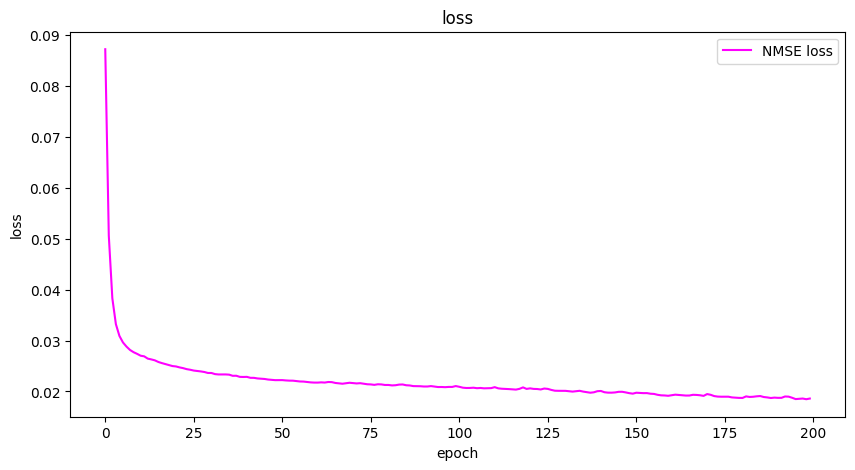

In [56]:

plt.figure(figsize=(10,5))
plt.title("loss")
plt.plot(train_loss,label="NMSE loss",linestyle='-',color='magenta')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()



## Test

In [57]:
import time
data_num_test=1000
data_num_file=1000
H_test=zeros((data_num_test,Nr,Nt,2*fre), dtype=float)
H_test_noisy=zeros((data_num_test,Nr_beam,Nt_beam,2*fre), dtype=float)
filedir = os.listdir('/content/CNN4CE/SF-CNN/2fre_data')  # type the path of testing data (different channel statistics from training data, used for performance evaluation)
n=0
SNRr=0
SNR_factor=5.9
for filename in filedir:
    newname = os.path.join('/content/CNN4CE/SF-CNN/2fre_data', filename)
    data = sio.loadmat(newname)
    channel = data['ChannelData_fre']
    for i in range(data_num_file):
        for j in range(fre):
            a=channel[:,:,j,i]
            H = np.transpose(a)
            H_re = np.real(H)
            H_im = np.imag(H)
            H_test[n*data_num_file+i, :, :, 2 * j] = H_re / scale
            H_test[n*data_num_file+i, :, :, 2 * j + 1] = H_im / scale
            N = np.random.normal(0, 1 / np.sqrt(2), size=(Nr, Nt_beam)) + 1j * np.random.normal(0, 1 / np.sqrt(2), size=(Nr, Nt_beam))
            NpinvF = np.dot(N, pinvF)
            Y = H + 1.0 / np.sqrt(SNR_factor*SNR) * NpinvF
            SNRr = SNRr + SNR_factor*SNR * (LA.norm(H)) ** 2 / (LA.norm(NpinvF)) ** 2
            Y_re = np.real(Y)
            Y_im = np.imag(Y)
            H_test_noisy[n*data_num_file+i, :, :, 2 * j] = Y_re / scale
            H_test_noisy[n*data_num_file+i, :, :, 2 * j + 1] = Y_im / scale
    n = n + 1
print('n =',n)
print(SNRr/(data_num_test*fre))
print(H_test.shape,H_test_noisy.shape)
index3 = np.where(abs(H_test) > 1)
row_num = np.unique(index3[0])
H_test = np.delete(H_test, row_num, axis=0)
H_test_noisy = np.delete(H_test_noisy, row_num, axis=0)
print(len(row_num))
print(H_test.shape, H_test_noisy.shape)

H_test=(torch.permute(torch.tensor(H_test , dtype = torch.float32),(0,3,1,2))).to(device)
H_test_noisy=torch.permute(torch.tensor(H_test_noisy,dtype = torch.float32),(0,3,1,2)).to(device)
print(H_test.shape, H_test_noisy.shape)
print(((H_test)**2).mean())



n = 1
0.987987337375977
(1000, 16, 32, 4) (1000, 16, 32, 4)
1
(999, 16, 32, 4) (999, 16, 32, 4)
torch.Size([999, 4, 16, 32]) torch.Size([999, 4, 16, 32])
tensor(0.0208, device='cuda:0')


In [59]:
model.eval()

t1=time.time()
decoded_channel = model(H_test_noisy)
t2=time.time()
nmse2=torch.zeros((data_num_test-len(row_num),1), dtype=torch.float32)
for n in range(data_num_test-len(row_num)):
    MSE=((H_test[n,:,:,:]-decoded_channel[n,:,:,:])**2).sum()
    norm_real=((H_test[n,:,:,:])**2).sum()
    nmse2[n]=MSE/norm_real
print('NMSE after training stage (testing performance) = ',nmse2.sum()/(data_num_test-len(row_num)))  # calculate NMSE after training stage (testing performance)

print('t2-t1 = ',t2-t1)

NMSE after training stage (testing performance) =  tensor(3.8345, grad_fn=<DivBackward0>)
t2-t1 =  0.01208949089050293
